# Searching for Good Weights in a Linear Model

In [1]:
import wget
import zipfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas  # for reading csv file
from IPython.display import display, clear_output  # for animations later in this notebook

First, let's find and download some interesting data.  The [machine learning repository at the University of California, Irvine](http://archive.ics.uci.edu/ml), is a great resource for publicly available data with explanations for machine learning researchers.  Here we download the air quality data set.  If `curl` is not available on your system, you may use the above link to find and download this data.  It is useful to go the link and find the page describing this data set. That page is [here](http://archive.ics.uci.edu/ml/datasets/Air+quality).

In [2]:
# Remove comment to download the data Comment

# wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip')
# with zipfile.ZipFile('AirQualityUCI.zip', 'r') as zip_ref:
#     zip_ref.extractall()


We will use the [pandas](https://pandas.pydata.org/) package to read this data.  The `pandas.read_csv` function is extremely useful for reading in all kinds of data with various peculiarities.  Here are the first few lines of `AirQualityUCI.csv`.

Notice a few things.  Fields are separated by semi-colons.  The first line is names for each variable, appearing in separate columns.  Each row is one sample.  Each line ends with two semi-colons. Not immediately obvious is that the decimal values follow the European convention of using a comma instead of decimal point.  Not demonstrated in these first few lines is the fact that missing measurements are given the value -200.

All of these issues can be dealt with directly in the call to `pandas.read_csv`.  I don't mean to imply that I got this right on my first try.  The two most puzzling issues were the two semi-colons at the end of each line and the commas for decimal points.  The double semi-colons caused the data returned by `pandas.read_csv` to have more columns than I expected.

Very good [pandas tutorials](http://pandas.pydata.org/pandas-docs/stable/tutorials.html) are available.

In [3]:
data = pandas.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', usecols=range(15), na_values=-200)
data = data.dropna(axis=0)
data.shape

(827, 15)

So, we have 827 rows and 15 columns of data.  This means that we read 827 samples that do not have missing values, and each sample contains 15 values.  Let's look at the first few rows of this data matrix, called a `DataFrame` in `pandas`.

In [4]:
data.head(10)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
5,10/03/2004,23.00.00,1.2,1197.0,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848
6,11/03/2004,00.00.00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603
7,11/03/2004,01.00.00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702
8,11/03/2004,02.00.00,0.9,1094.0,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648
11,11/03/2004,05.00.00,0.7,1066.0,8.0,1.1,512.0,16.0,1918.0,28.0,1182.0,422.0,11.0,56.2,0.7366


Let's create a simple problem for playing with this data.  Let's say we want to predict the level of carbon monoxide from the time of day.  The column `Time` contains the hour, but not just the hour.  9am will appear as 09.00.00.  Whoopee!  This will give us a chance to practice our skills at extracting substrings, converting strings to integers, and doing these steps for all of the `Time` values within a concise little list comprehension.  You don't know what this is?  Well, it is time to get comfortable not knowing, and typing 'python list comprehension' into your favorite web search engine.

In [5]:
data['Time'][:10]

0     18.00.00
1     19.00.00
2     20.00.00
3     21.00.00
4     22.00.00
5     23.00.00
6     00.00.00
7     01.00.00
8     02.00.00
11    05.00.00
Name: Time, dtype: object

In [6]:
[t for t in data['Time'][:10]]

['18.00.00',
 '19.00.00',
 '20.00.00',
 '21.00.00',
 '22.00.00',
 '23.00.00',
 '00.00.00',
 '01.00.00',
 '02.00.00',
 '05.00.00']

In [7]:
[t[:2] for t in data['Time'][:10]]

['18', '19', '20', '21', '22', '23', '00', '01', '02', '05']

In [8]:
[int(t[:2]) for t in data['Time'][:10]]

[18, 19, 20, 21, 22, 23, 0, 1, 2, 5]

In [9]:
hour = [int(t[:2]) for t in data['Time']]
hour

[18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 5,
 6,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 5,
 6,
 7,
 8,
 9,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 16,
 17,
 18,
 19,
 20,
 21,

To get the carbon monoxide measurements for each sample, you can read the data description at the UCI web site to learn that column `CO(GT)` is the ground truth measurement of carbon monoxide.

In [10]:
data.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

In [11]:
CO = data['CO(GT)']
CO[:10]

0     2.6
1     2.0
2     2.2
3     2.2
4     1.6
5     1.2
6     1.2
7     1.0
8     0.9
11    0.7
Name: CO(GT), dtype: float64

**Here I will introduce a convention I will follow throughout this class.** \

Inputs to a model are given in a matrix named `X`.  **Samples are in rows, and the components, measurements, variables, thingies of each sample are given in the columns.**  The desired, correct outputs for each sample are given in a matrix named `T`, for **T**argets.  The $i^{th}$ row of `X` is Sample $i$ whose correct target output is in row $i$ of `T`.  Yes, you excellent software developers, `X` and `T` are parallel arrays, which should set of alarms in your coding brains.  As long as we remember that we cannot reorder the rows n `X` without doing the same reording of rows in `T`, we will be okay.

Let's set this up for our hour to CO problem.

In [12]:
T = CO
T = np.array(T).reshape((-1, 1))  # make T have one column and as many rows as needed to hold the values of T
Tnames = ['CO']
X = np.array(hour).reshape((-1, 1))
Xnames = ['Hour']
print('X.shape =', X.shape, 'Xnames =', Xnames, 'T.shape =', T.shape, 'Tnames =', Tnames)
# or, using the latest formatting ability in python strings,
print(f'{X.shape=}, {Xnames=}, {T.shape=}, {Tnames=}')

X.shape = (827, 1) Xnames = ['Hour'] T.shape = (827, 1) Tnames = ['CO']
X.shape=(827, 1), Xnames=['Hour'], T.shape=(827, 1), Tnames=['CO']


Say after me...plot early and often!  We can never have too many visualizations.  This next plot verifies that we have defined `X` and `T` correctly.  What else do you notice?

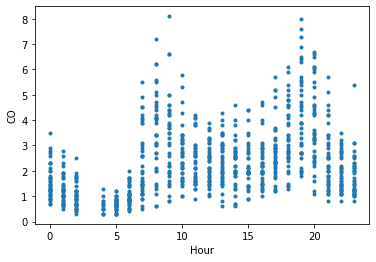

In [13]:
plt.plot(X, T, '.')
plt.xlabel(Xnames[0])
plt.ylabel(Tnames[0]);  # semi-colon here prevents printing the cryptic result of call to plt.ylabel()

Well, what do you think?  Will we be able to predict `CO` from `Hour` with a linear model?  The predictions of linear model must appear as a straight line in this plot.

What is a linear model?  Well, a linear model of one variable is specified with a y-intercept and a slope.  These are the two parameters of the linear model.  Let's call them `w0` and `w1`.  If the output of the linear model is `y`, then we have `y = w0 + x * w1`.  Let's wrap this up in a little function.

In [14]:
def linear_model(x, w0, w1):
    return w0 + x * w1

So, what values should we use for `w0` and `w1` to make a good prediction of `CO`?  What method shall we use to find good values?  How about good old guessing, or maybe we could call this trial and error.  We will just pick some values and plot the predictions.

## Manual Guessing

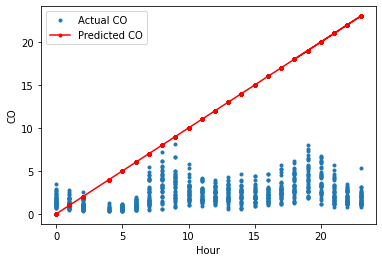

In [15]:
w0 = 0
w1 = 1

Y = linear_model(X, w0, w1)

plt.plot(X, T, '.', label='Actual CO')
plt.plot(X, Y, 'r.-', label='Predicted CO')
plt.xlabel(Xnames[0])
plt.ylabel(Tnames[0])
plt.legend();  # make legend using the label strings

Well, clearly our predictions are climbing much too quickly  The slope, or `w1`, is too high.  Try a smaller value.

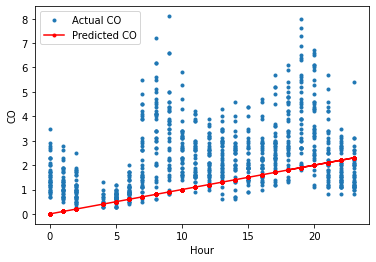

In [16]:
w1 = 0.1
Y = linear_model(X, w0, w1)

plt.plot(X, T, '.', label='Actual CO')
plt.plot(X, Y, 'r.-', label='Predicted CO')
plt.xlabel(Xnames[0])
plt.ylabel(Tnames[0])
plt.legend(); 

Maybe too low.

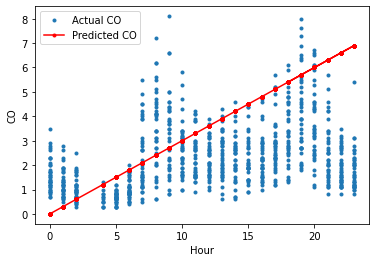

In [17]:
w1 = 0.3
Y = linear_model(X, w0, w1)

plt.plot(X, T, '.', label='Actual CO')
plt.plot(X, Y, 'r.-', label='Predicted CO')
plt.xlabel(Xnames[0])
plt.ylabel(Tnames[0])
plt.legend(); 

Okay.  Now we can try to increase the y-intercept, `w0`, a bit.

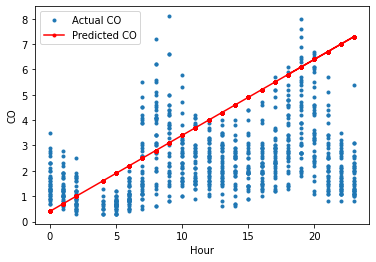

In [18]:
w0 = 0.4
Y = linear_model(X, w0, w1)

plt.plot(X, T, '.', label='Actual CO')
plt.plot(X, Y, 'r.-', label='Predicted CO')
plt.xlabel(Xnames[0])
plt.ylabel(Tnames[0])
plt.legend(); 

We could do this all day.  (Well, maybe a few more times.)  What we really need is a way to quantify how good our linear model is doing.  Let's define a function to calculate the error by calling `linear_model` to get our predictions, `Y`,  and compare them to the target `T` values.  The comparison will be done with the common root-mean-square-error, or RMSE, approach, for which the difference between `T` and `Y` is squared, averaged, and the square root of the result is returned.

In [19]:
def rmse(X, T, w0, w1):
    Y = linear_model(X, w0, w1)
    return np.sqrt(np.mean((T - Y)**2))

Now we are ready to automate the guessing approach we attempted above.  Let's define a search algorithm that

   - bumps a weight up and down to determine which direction decreases the error,
   - repeatedly shift that weight in that direction until the error increases, and
   - repeat these steps with the other weight, and
   - repeat all steps multiple times.
   
This search algorithm is sometimes called [coordinate descent](https://en.wikipedia.org/wiki/Coordinate_descent).

## Coordinate Descent

In [20]:
w0 = 0.4
w1 = 0.5
dw = 0.1   # How much to change a weight's value.

current_error = rmse(X, T, w0, w1)
up_error = rmse(X, T, w0 + dw, w1)
down_error = rmse(X, T, w0 - dw, w1)
print(current_error, up_error, down_error)

if down_error < current_error:
    dw = -dw
    new_error = down_error
else:
    new_error = up_error
    
while new_error <= current_error:
    current_error = new_error
    w0 = w0 + dw
    new_error = rmse(X, T, w0, w1)
    print(f'{w0=:5.2f} {new_error=:.2f}')

5.216194204884568 5.2953094619163386 5.137807087530826
w0= 0.30 new_error=5.14
w0= 0.20 new_error=5.06
w0= 0.10 new_error=4.98
w0= 0.00 new_error=4.91
w0=-0.10 new_error=4.83
w0=-0.20 new_error=4.76
w0=-0.30 new_error=4.68
w0=-0.40 new_error=4.61
w0=-0.50 new_error=4.54
w0=-0.60 new_error=4.47
w0=-0.70 new_error=4.40
w0=-0.80 new_error=4.33
w0=-0.90 new_error=4.27
w0=-1.00 new_error=4.20
w0=-1.10 new_error=4.14
w0=-1.20 new_error=4.08
w0=-1.30 new_error=4.02
w0=-1.40 new_error=3.96
w0=-1.50 new_error=3.90
w0=-1.60 new_error=3.84
w0=-1.70 new_error=3.79
w0=-1.80 new_error=3.74
w0=-1.90 new_error=3.69
w0=-2.00 new_error=3.64
w0=-2.10 new_error=3.59
w0=-2.20 new_error=3.55
w0=-2.30 new_error=3.51
w0=-2.40 new_error=3.47
w0=-2.50 new_error=3.43
w0=-2.60 new_error=3.40
w0=-2.70 new_error=3.37
w0=-2.80 new_error=3.34
w0=-2.90 new_error=3.31
w0=-3.00 new_error=3.29
w0=-3.10 new_error=3.27
w0=-3.20 new_error=3.25
w0=-3.30 new_error=3.24
w0=-3.40 new_error=3.23
w0=-3.50 new_error=3.22
w0=-3.60 

In [21]:
dw = 0.1
current_error = rmse(X, T, w0, w1)
up_error = rmse(X, T, w0, w1 + dw)
down_error = rmse(X, T, w0, w1 - dw)
print(current_error, up_error, down_error)

if down_error < current_error:
    dw = -dw
    new_error = down_error
else:
    new_error = up_error
    
while new_error <= current_error:
    current_error = new_error
    w1 = w1 + dw
    new_error = rmse(X, T, w0, w1)
    print('w1 = {:.2f} new_error = {:.5f}'.format(w1, new_error))

3.215684807116248 4.008729893209443 2.9134927741634757
w1 = 0.40 new_error = 2.91349
w1 = 0.30 new_error = 3.24243


Lot's of repeated code here.  We don't want to copy and paste for each iteration.  All steps are put together in the following function.

In [22]:
# Need a function for this.  Let's optimize w_bias then w
def coordinate_descent(errorF, X, T, w0, w1, dw, nSteps):
    step = 0
    current_error = errorF(X, T, w0, w1)
    error_sequence = [current_error]
    W_sequence = [[w0, w1]]
    changed = False

    while step < nSteps:

        step += 1
        
        if not changed:
            dw = dw * 0.1
            
        changed = False
        
        # first vary w_bias
        up_error = errorF(X, T, w0 + dw, w1)
        down_error = errorF(X, T, w0 - dw, w1)
        
        if down_error < current_error:
            dw = -dw
            
        while True:
            new_w0 = w0 + dw
            new_error = errorF(X, T, new_w0, w1)
            if new_error >= current_error or step > nSteps:
                break
            changed = True
            w0 = new_w0
            W_sequence.append([w0, w1])
            error_sequence.append(new_error)
            current_error = new_error
            step += 1

        # now vary w
        up_error = errorF(X, T, w0, w1 + dw)
        down_error = errorF(X, T, w0, w1 - dw)
        
        if down_error < current_error:
            dw = -dw
            
        while True:
            new_w1 = w1 + dw
            new_error = errorF(X, T, w0, new_w1)
            if new_error >= current_error or step > nSteps:
                break
            changed = True
            w1 = new_w1
            W_sequence.append([w0, w1])
            error_sequence.append(new_error)
            current_error = new_error
            step += 1

    return w0, w1, error_sequence, W_sequence

We will need some functions to help us create plots showing the error going down and the sequence of weight values that were tried.

In [23]:
def plot_sequence(error_sequence, W_sequence, label):
    plt.subplot(1, 2, 1)
    plt.plot(error_sequence, 'o-', label=label)
    plt.xlabel('Steps')
    plt.ylabel('Error')
    plt.legend()
    plt.subplot(1, 2, 2)
    W_sequence = np.array(W_sequence)
    plt.plot(W_sequence[:, 0], W_sequence[:, 1], '.-', label=label)
    plot_error_surface()

def plot_error_surface():
    n = 20
    w0s = np.linspace(-5, 5, n) 
    w1s = np.linspace(-0.5, 1.0, n) 
    w0s, w1s = np.meshgrid(w0s, w1s)
    surface = []
    for w0i in range(n):
        for w1i in range(n):
            surface.append(rmse(X, T, w0s[w0i, w1i], w1s[w0i, w1i]))
    plt.contourf(w0s, w1s, np.array(surface).reshape((n, n)), cmap='bone')
    # plt.colorbar()
    plt.xlabel('w_bias')
    plt.ylabel('w')
    
def show_animation(model, error_sequence, W_sequence, X, T, label):
    W_sequence = np.array(W_sequence)
    fig = plt.figure(figsize=(15, 8))
    plt.subplot(1, 3, 1)
    error_line, = plt.plot([], [])
    plt.xlim(0, len(error_sequence))
    plt.ylim(0, max(error_sequence))

    plt.subplot(1, 3, 2)
    plot_error_surface()
 
    w_line, = plt.plot([], [], '.-', label=label)
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(X, T, 'o')
    model_line, = plt.plot([], [], 'r-', lw=3, alpha=0.5, label=label)
    plt.xlim(0, 24)
    plt.ylim(np.min(T), np.max(T))

    for i in range(len(W_sequence)):
        
        error_line.set_data(range(i), error_sequence[:i])
        w_line.set_data(W_sequence[:i, 0], W_sequence[:i, 1])
        Y = model(X, W_sequence[i, 0], W_sequence[i, 1])
        model_line.set_data(X, Y)

        plt.pause(0.001)

        clear_output(wait=True)
        display(fig)

In [24]:
w0 = -2
w1 = 0.5
nSteps = 200
dw = 10
w0, w1, error_sequence, W_sequence = coordinate_descent(rmse, X, T, w0, w1, dw, nSteps)
print(f'Coordinate Descent: Error is {rmse(X, T, w0, w1):.2f}   W is {w0:.2f}, {w1:.2f}')

Coordinate Descent: Error is 1.33   W is 1.21, 0.09


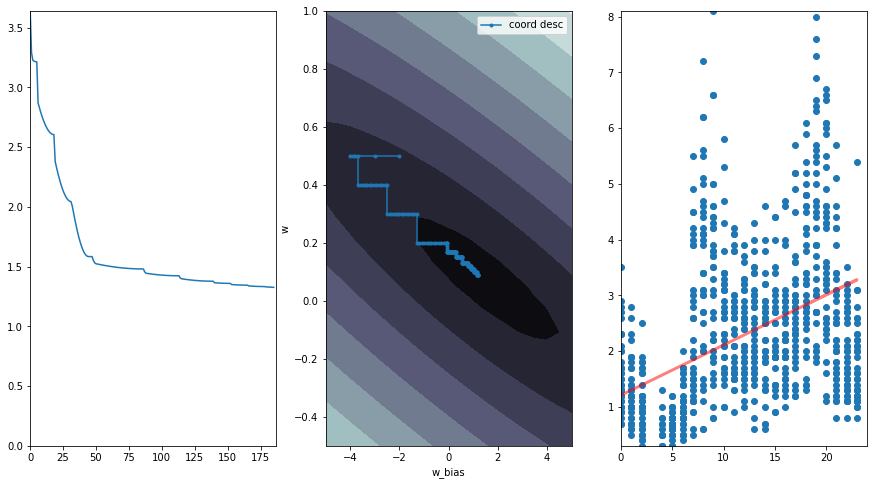

In [25]:
show_animation(linear_model, error_sequence, W_sequence, X, T, 'coord desc')

Okay, well that's fun, but this becomes kind of silly when we try to apply this to other models that have more weights, like thousands, or millions.  Instead, we need a way to find a direction in which we can change both weights, meaning all weights, on each step.  

## Run and Twiddle

How about this?  Take a step in some direction.  If error decreases, continue in that direction.  If error does not decrease, pick a random direction.  Repeat.

This has been called "run and twiddle", or "run and tumble".  [This Wikipedia page](https://en.wikipedia.org/wiki/Flagellum#Motor) describes how single cell organisms use cilia in their cell membranes to provide locomotion, either in the current direction as they move in a coordinated fashion, or to cause a spin to change direction.

Now we will be changing w_bias and w together, so that we can step through the 2-d weight space in particular directions.  Representing our two weights as a two-component vector, and rewriting some functions to accept a vector, simplifies the code a bit.  We will actually represent the weights, W, as a column matrix of two components.  It will look like

$$W =\begin{bmatrix} w_{bias}  \\ w  \end{bmatrix}$$

Let's add a couple of functions to code the application of our model to data, and to calculate the root-mean-square error that we wish to minimize.  Then we will modify a bit the plotting functions to accept the name of the model function.  We will use a different model towards the end of these notes.

In [26]:
def linear_model(X, W):
    # W is column vector
    return X @ W[1:, :] + W[0, :]

def rmse(model, X, T, W):
    Y = model(X, W)
    return np.sqrt(np.mean((T - Y)**2))

In [64]:
######################################################################

def vector_length(v):
    return np.sqrt(v.T @ v)

def run_and_twiddle(model_f, rmse_f, X, T, W, dW, nSteps):
    step = 0
    current_error = rmse_f(model_f, X, T, W)
    error_sequence = [current_error]
    W_sequence = [W.flatten()]
    nFails = 0
    
    while step < nSteps:
        new_direction = np.random.uniform(-1, 1, size=(2, 1))

        print(f'{step=}')
        print(f'{nFails=}, {new_direction=}')
        
        new_direction = dW * new_direction / vector_length(new_direction)
        if nFails > 10:
            dW = dW * 0.8
        while step < nSteps:
            new_W = W.copy() + new_direction
            new_error = rmse_f(model_f, X, T, new_W)
            step += 1
        
            print(f'{new_error=}, {current_error=}', '\n')
            
            if new_error >= current_error:
                nFails += 1
                break
            nFails = 0
            
            print('good', f'{new_direction=}', '\n')
            
            W = new_W
            W_sequence.append(W.flatten())
            error_sequence.append(new_error)
            current_error = new_error

    return W, error_sequence, W_sequence

In [65]:
def plot_error_surface(model):
    n = 20
    wbiass = np.linspace(-5, 5, n)
    ws = np.linspace(-0.5, 1.0, n)
    wbiass, ws = np.meshgrid(wbiass, ws)
    surface = []
    for wbi in range(n):
        for wi in range(n):
            W = np.array([wbiass[wbi, wi], ws[wbi, wi]]).reshape(-1, 1)
            surface.append(rmse(model, X, T, W))
    plt.contourf(wbiass, ws, np.array(surface).reshape((n, n)), cmap='bone')
    # plt.colorbar()
    plt.xlabel('w_bias')
    plt.ylabel('w')
    
def show_animation(model, error_sequence, W_sequence, X, T, label):
    W_sequence = np.array(W_sequence)
    fig = plt.figure(figsize=(15, 8))
    plt.subplot(1, 3, 1)
    error_line, = plt.plot([], [])
    plt.xlim(0, len(error_sequence))
    plt.ylim(0, max(error_sequence))

    plt.subplot(1, 3, 2)
    plot_error_surface(model)
 
    w_line, = plt.plot([], [], '.-', label=label)
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(X, T, 'o')
    model_line, = plt.plot([], [], 'r-', lw=3, alpha=0.5, label=label)
    plt.xlim(0, 24)
    plt.ylim(np.min(T), np.max(T))

    for i in range(len(W_sequence)):
        
        error_line.set_data(range(i), error_sequence[:i])
        w_line.set_data(W_sequence[:i, 0], W_sequence[:i, 1])
        Y = model(X, W_sequence[i:i + 1, :].T)
        model_line.set_data(X, Y)

        plt.pause(0.001)

        clear_output(wait=True)
        display(fig)

In [67]:
w_bias = -2 # 10
w = 0.5
W = np.array([w_bias, w]).reshape(-1, 1)
nSteps = 300
dW = 10

W, error_sequence, W_sequence = run_and_twiddle(linear_model, rmse, X, T, W, dW, nSteps)
print('Run and Twiddle:  Error is {:.2f}   W is {:.2f}, {:.2f}'.format(rmse(linear_model, X, T, W), W[0,0], W[1,0]))

step=0
nFails=0, new_direction=array([[0.01834629],
       [0.41659529]])
new_error=142.42264288764554, current_error=3.6400267083809594 

step=1
nFails=1, new_direction=array([[0.07682817],
       [0.82329279]])
new_error=142.37878463065465, current_error=3.6400267083809594 

step=2
nFails=2, new_direction=array([[ 0.91637446],
       [-0.35093375]])
new_error=38.862926726885625, current_error=3.6400267083809594 

step=3
nFails=3, new_direction=array([[ 0.20504714],
       [-0.78137936]])
new_error=129.54086121244328, current_error=3.6400267083809594 

step=4
nFails=4, new_direction=array([[-0.24956451],
       [ 0.657354  ]])
new_error=130.05748704593827, current_error=3.6400267083809594 

step=5
nFails=5, new_direction=array([[ 0.00214605],
       [-0.24207816]])
new_error=136.23711590355745, current_error=3.6400267083809594 

step=6
nFails=6, new_direction=array([[-0.74437626],
       [ 0.79912039]])
new_error=99.01164555966609, current_error=3.6400267083809594 

step=7
nFails=7, n

new_error=1.3198027483773338, current_error=1.3197637168998595 

step=194
nFails=2, new_direction=array([[ 0.87180258],
       [-0.44996636]])
new_error=1.3197916454920804, current_error=1.3197637168998595 

step=195
nFails=3, new_direction=array([[0.07083613],
       [0.14217187]])
new_error=1.3197962696039829, current_error=1.3197637168998595 

step=196
nFails=4, new_direction=array([[0.54655088],
       [0.49511082]])
new_error=1.3197759906444477, current_error=1.3197637168998595 

step=197
nFails=5, new_direction=array([[0.30921177],
       [0.11148205]])
new_error=1.3197588747874744, current_error=1.3197637168998595 

good new_direction=array([[0.00100035],
       [0.00036066]]) 

new_error=1.3197805258948214, current_error=1.3197588747874744 

step=199
nFails=1, new_direction=array([[0.80084448],
       [0.90240338]])
new_error=1.3198297025180585, current_error=1.3197588747874744 

step=200
nFails=2, new_direction=array([[-0.76570671],
       [ 0.70913096]])
new_error=1.319810018

nFails=15, new_direction=array([[-0.83892509],
       [ 0.94600013]])
new_error=1.3197476386494273, current_error=1.3197476240601058 

step=284
nFails=16, new_direction=array([[ 0.06330866],
       [-0.13813598]])
new_error=1.3197476364330196, current_error=1.3197476240601058 

step=285
nFails=17, new_direction=array([[0.67976811],
       [0.69684517]])
new_error=1.3197476311064882, current_error=1.3197476240601058 

step=286
nFails=18, new_direction=array([[-0.34791871],
       [ 0.41871133]])
new_error=1.3197476284066523, current_error=1.3197476240601058 

step=287
nFails=19, new_direction=array([[-0.48699744],
       [-0.35778086]])
new_error=1.3197476255755678, current_error=1.3197476240601058 

step=288
nFails=20, new_direction=array([[0.06803637],
       [0.52616467]])
new_error=1.319747627432786, current_error=1.3197476240601058 

step=289
nFails=21, new_direction=array([[-0.36870469],
       [ 0.07086422]])
new_error=1.3197476241688022, current_error=1.3197476240601058 

step=2

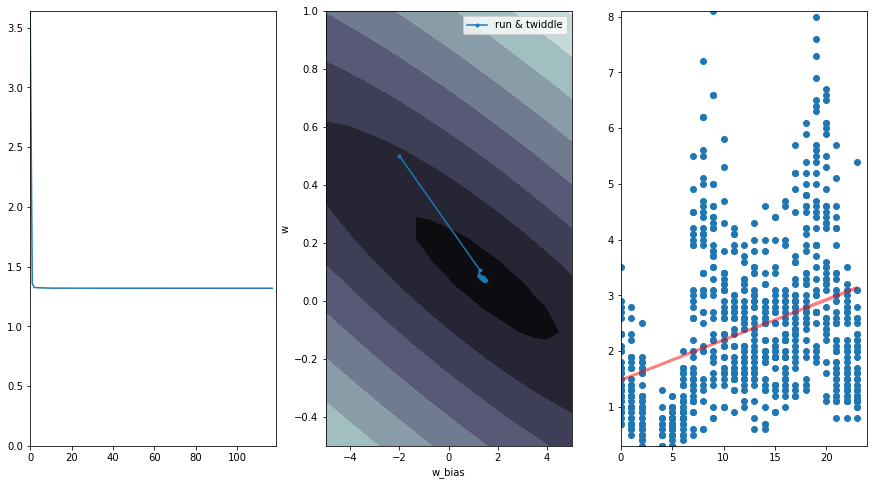

In [68]:
show_animation(linear_model, error_sequence, W_sequence, X, T, 'run & twiddle')

## Gradient Descent

Let's call the output of our model `Y` and the error being minimized `E`. 

To perform gradient descent, we need $\frac{\partial E}{\partial W}$.  Let's call this `dEdW`.  The calculation of this can be divided into two factors, using the chain rule.

$$\begin{align*}
  \frac{\partial E}{\partial W} &= \frac{\partial E}{\partial Y} \frac{\partial Y}{\partial W}
  \end{align*}$$
  
The error we want to minimize is the squared error, $(T - Y)^2$, and $Y =X W$, so

$$\begin{align*}
  \frac{\partial E}{\partial W} &= \frac{\partial E}{\partial Y} \frac{\partial Y}{\partial W} \\
  \frac{\partial E}{\partial W} &= \frac{\partial (T-Y)^2}{\partial Y} \frac{\partial X W}{\partial W} \\
  \frac{\partial E}{\partial W} &= -2 (T - Y) X 
    \end{align*}$$
    
In python, we have

    dYdW = X
    dEdY = -2 * (T - Y)
    dEdW = dEdY.T @ dYdW 

**have to divide dEdW by n_samples to get mean of error minimized**
    
    
with some other subtle things to allow us to include the bias weight $w_0$ in the calculations.
    

In [ ]:
# Still using linear_model as defined above

#def linear_model(X, W):
#    # W is column vector
#    return X @ W[1:, :] + W[0,:]

In [99]:
def dYdW(X, T, W):
    # One row per sample in X,T.  One column per W component.
    # For first one, is constant 1.
    # For second one, is value of X
    return np.insert(X, 0, 1, axis=1)

def dEdY(X, T, W):
    Y = linear_model(X, W)
    return -2 * (T - Y)
    
def dEdW(X, T, W):
    result = dEdY(X, T, W).T @ dYdW(X, T, W) / (X.shape[0])  # (X.shape[0]) is the number of observations
    return result.T 

In [104]:
def gradient_descent(model_f, gradient_f, rmse_f, X, T, W, rho, nSteps):
    error_sequence = []
    W_sequence = []
    for step in range(nSteps):
        
        error_sequence.append(rmse_f(model_f, X, T, W))
        W_sequence.append(W.flatten())
        
        W -= rho * gradient_f(X, T, W)  # HERE IS THE WHOLE ALGORITHM!!
        
    return W, error_sequence, W_sequence

In [105]:
w_bias = -2 # 10
w = 0.5
W = np.array([w_bias, w]).reshape(-1, 1)

nSteps = 200
rho = 0.005

W, error_sequence, W_sequence = gradient_descent(linear_model, dEdW, rmse, X, T, W, rho, nSteps)
print('Gradient Descent:  Error is {:.2f}   W is {}'.format(rmse(linear_model, X, T, W), W))

Gradient Descent:  Error is 1.69   W is [[-0.67580432]
 [ 0.20701698]]


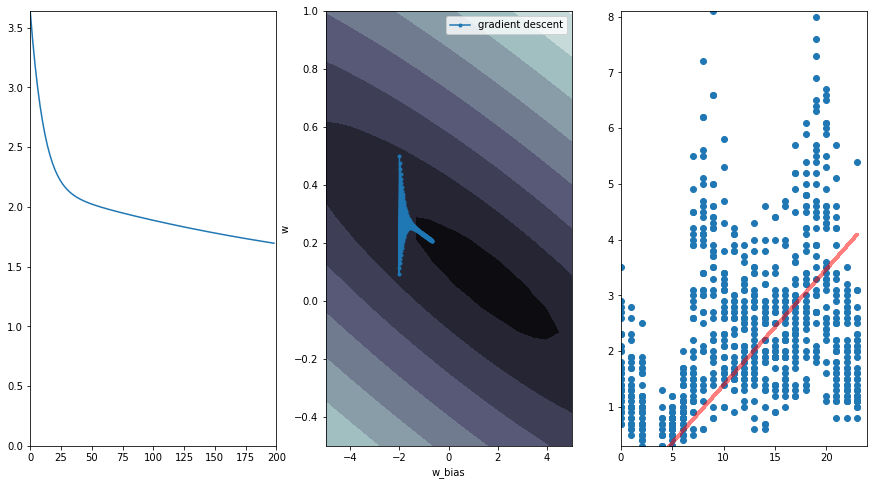

In [106]:
show_animation(linear_model, error_sequence, W_sequence, X, T, 'gradient descent')

Now let's try a recently developed variation of the gradient descent method, called Adam, for adaptive moment estimation.  See [ADAM: A Method for Stochastic Optimization](https://arxiv.org/pdf/1412.6980.pdf) by Diederik P. Kingma and Jimmy Lei Ba.

In [107]:
def gradient_descent_adam(model_f, gradient_f, rmse_f, X, T, W, rho, nSteps):
    # Commonly used parameter values
    alpha = rho
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    m = 0
    v = 0
    
    error_sequence = []
    W_sequence = []
    for step in range(nSteps):
        error_sequence.append(rmse_f(model_f, X, T, W))
        W_sequence.append(W.flatten())
        
        g = gradient_f(X, T, W)
        
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g * g
        mhat = m / (1 - beta1 ** (step+1))
        vhat = v / (1 - beta2 ** (step+1))
        
        W -= alpha * mhat / (np.sqrt(vhat) + epsilon)
        
    return W, error_sequence, W_sequence

In [108]:
w_bias = -2 # 10
w = 0.5
W = np.array([w_bias, w]).reshape(-1, 1)

rho = 0.01
nSteps = 200

W, error_sequence, W_sequence = gradient_descent_adam(linear_model, dEdW, rmse, X, T, W, rho, nSteps)
print('Adam:  Error is {:.2f}   W is {:.2f}, {:.2f}'.format(rmse(linear_model, X, T, W), W[0,0], W[1,0]))

Adam:  Error is 1.70   W is -0.71, 0.21


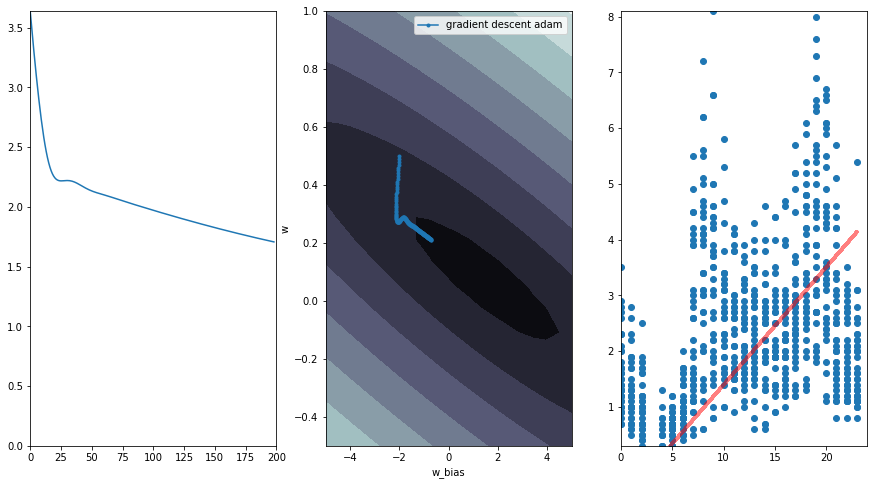

In [109]:
show_animation(linear_model, error_sequence, W_sequence, X, T, 'gradient descent adam')

# Let's Try a Slightly Nonlinear Model

Let's make a quadratic model now.  The equation for the output of this model for the $i^{th}$ sample is

$$ y_i = w_0 + w_1 x_i + w_2 x_i^2$$

In [110]:
X

array([[18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [ 0],
       [ 1],
       [ 2],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [ 0],
       [ 1],
       [ 2],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [ 0],
       [ 1],
       [ 2],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [ 0],
       [ 1],
       [ 2],
       [ 5],
       [ 6],
       [ 7],

In [111]:
X ** 2

array([[324],
       [361],
       [400],
       [441],
       [484],
       [529],
       [  0],
       [  1],
       [  4],
       [ 25],
       [ 36],
       [ 49],
       [ 64],
       [ 81],
       [100],
       [121],
       [144],
       [169],
       [196],
       [225],
       [256],
       [289],
       [324],
       [361],
       [400],
       [441],
       [484],
       [529],
       [  0],
       [  1],
       [  4],
       [ 25],
       [ 36],
       [ 49],
       [ 64],
       [100],
       [121],
       [144],
       [169],
       [196],
       [225],
       [256],
       [289],
       [324],
       [361],
       [400],
       [441],
       [484],
       [529],
       [  0],
       [  1],
       [  4],
       [ 25],
       [ 36],
       [ 49],
       [ 64],
       [ 81],
       [100],
       [121],
       [144],
       [169],
       [196],
       [225],
       [256],
       [289],
       [324],
       [361],
       [400],
       [441],
       [484],
       [529],
      

In [112]:
X ** [1, 2]

array([[ 18, 324],
       [ 19, 361],
       [ 20, 400],
       ...,
       [ 22, 484],
       [ 23, 529],
       [  0,   0]])

In [113]:
max_degree = 2

In [114]:
X ** [0, 1, 2]

array([[  1,  18, 324],
       [  1,  19, 361],
       [  1,  20, 400],
       ...,
       [  1,  22, 484],
       [  1,  23, 529],
       [  1,   0,   0]])

In [115]:
range(max_degree)

range(0, 2)

In [ ]:
list(range(max_degree))

In [116]:
list(range(max_degree + 1))

[0, 1, 2]

In [120]:
X_powers = X ** range(max_degree + 1)
X_powers, X_powers.shape

(array([[  1,  18, 324],
        [  1,  19, 361],
        [  1,  20, 400],
        ...,
        [  1,  22, 484],
        [  1,  23, 529],
        [  1,   0,   0]]),
 (827, 3))

In [130]:
def nonlinear_model(X_powers, W):
    # W is column vector
    return X_powers @ W

In [131]:
def dYdW(X_powers, T, W):
    return X_powers

def dEdY(X_powers, T, W):
    Y = nonlinear_model(X_powers, W)
    return -2 * (T - Y)
    
# dEdW from before does not need to be changed.

In [133]:
max_degree = 5

w_bias = -2 #10
w_linear = 0.5

# w_bias = 0
# w_linear = 0

ws_nonlinear = np.zeros(max_degree + 1 - 2)
print(f'{ws_nonlinear=}')

W = np.hstack((w_bias, w_linear, *ws_nonlinear)).reshape(-1, 1)
print(f'{W=}')

rho = 0.01
nSteps = 400
X_powers = X ** range(max_degree + 1)

W, error_sequence, W_sequence = gradient_descent_adam(nonlinear_model, dEdW, rmse, X_powers, T, W, rho, nSteps)
print('Adam:  Error is {:.2f}   W is {:.2f}, {:.2f} {:.2f}'.format(rmse(nonlinear_model, X_powers, T, W), W[0,0], W[1,0], W[2,0]))

ws_nonlinear=array([0., 0., 0., 0.])
W=array([[-2. ],
       [ 0.5],
       [ 0. ],
       [ 0. ],
       [ 0. ],
       [ 0. ]])
Adam:  Error is 1.69   W is -2.00, 0.50 -0.00


Demonstrate    debugging    here

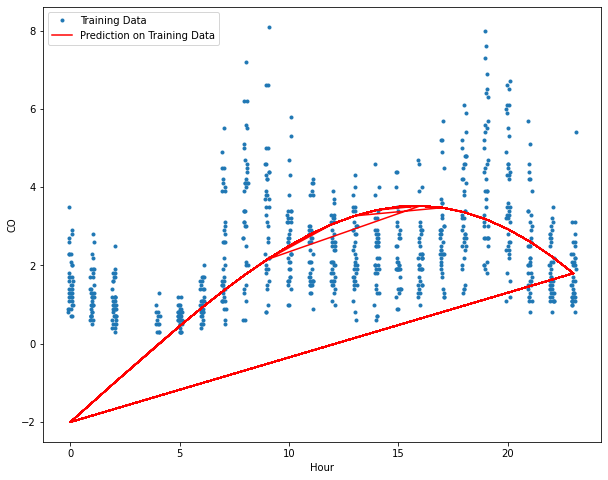

In [143]:
plt.figure(figsize=(10,8))
plt.plot(X + np.random.uniform(-0.1, 0.1, X.shape), T, '.', label='Training Data')

plt.plot(X, nonlinear_model(X_powers, W), 'ro', label='Prediction on Training Data')

plt.xlabel(Xnames[0])
plt.ylabel(Tnames[0])

plt.legend();

How would you change the previous code cell to plot a continuous red line?

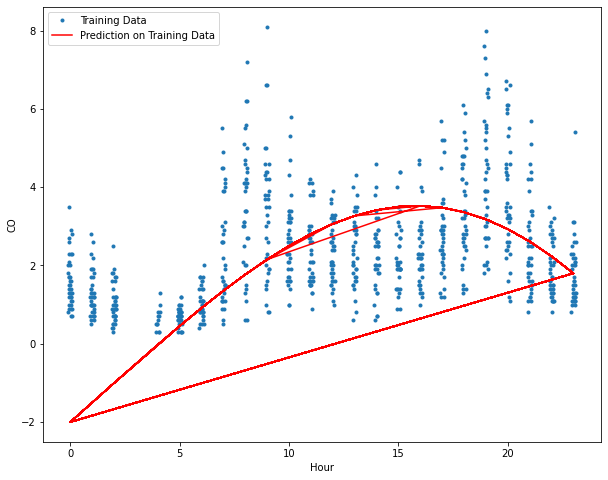

In [142]:
plt.figure(figsize=(10,8))
plt.plot(X + np.random.uniform(-0.1, 0.1, X.shape), T, '.', label='Training Data')

plt.plot(X, nonlinear_model(X_powers, W), 'r-', label='Prediction on Training Data')
#   only change is here --------------------^
plt.xlabel(Xnames[0])
plt.ylabel(Tnames[0])

plt.legend();

Whoops.

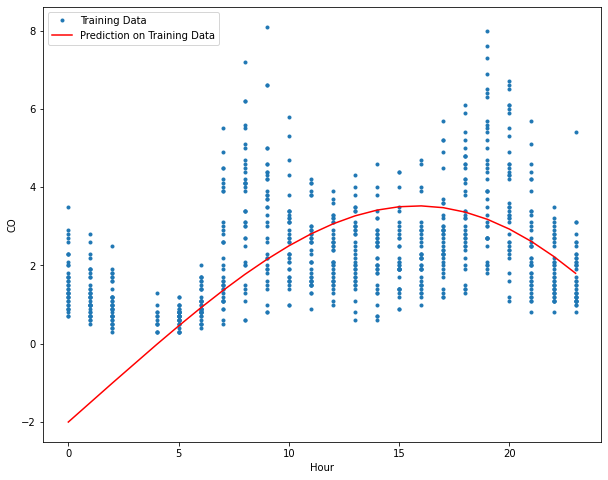

In [139]:
plt.figure(figsize=(10,8))
plt.plot(X, T, '.', label='Training Data')

order = np.argsort(X, axis=0).ravel()  # change to 1-dimensional vector
# print(order)
# print(X[order])
plt.plot(X[order], nonlinear_model(X_powers, W)[order], 'r', label='Prediction on Training Data')

plt.xlabel(Xnames[0])
plt.ylabel(Tnames[0])

plt.legend();